<a href="https://colab.research.google.com/github/PaulToronto/Stanford-Andrew-Ng-Machine-Learning-Specialization/blob/main/1_3_4_1_Lab_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Overfitting

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression, Ridge

## Functions

In [2]:
def munge(base, exp):
    if exp == 0:
        return ''
    if exp == 1:
        return base
    return base + f'^{{{exp}}}'

In [3]:
def map_one_feature(X1, degree):
    """
    Feature mapping function to polynomial features
    """
    X1 = np.atleast_1d(X1)
    out = []
    string = ''
    k = 0
    for i in range(1, degree + 1):
        out.append((X1 ** i))
        string = string + f"w_{{{k}}}{munge('x_0', i)} + "
        k += 1
    string += 'b'

    return np.stack(out, axis=1), string

In [4]:
def map_feature(X1, X2, degree):
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    out = []
    string = ''
    k = 0
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j) * (X2 ** j)))
            string = string + f"w_{{{k}}}{munge('X_0', i-j)}{munge('X_1', j)} + "
            k += 1
    string += 'b'

    return np.stack(out, axis=1), string

In [5]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray): Shape (m,n) input data, m examples, n features

    Returns:
      X_norm (ndarray): Shape (m,n)  input normalized by column
      mu (ndarray):     Shape (n,)   mean of each feature
      sigma (ndarray):  Shape (n,)   standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [6]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

In [7]:
def predict_logistic(X, w, b):
    return sigmoid(X @ w + b)

In [8]:
def plot_decision_boundary(ax,
                           x0r,
                           x1r,
                           predict,
                           w, b,
                           scaler = False,
                           mu=None, sigma=None, degree=None):
    """
    Plots a decision boundary
     Args:
      x0r : (array_like Shape (1,1)) range (min, max) of x0
      x1r : (array_like Shape (1,1)) range (min, max) of x1
      predict : function to predict z values
      scalar : (boolean) scale data or not
    """
    h = 0.01 # step size in the mesh

    # create a mesh to plot in
    xx, yy = np.meshgrid(np.arange(x0r[0], x1r[1], h),
                         np.arange(x1r[0], x1r[1], h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    points = np.c_[xx.ravel(), yy.ravel()]
    Xm,_ = map_feature(points[:, 0], points[:, 1],degree)
    if scaler:
        Xm = (Xm - mu)/sigma
    Z = predict(Xm, w, b)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z, levels = [0.5], colors='g')

## Overfit Example

In [9]:
from numpy.core.multiarray import MAY_SHARE_EXACT
def overfit_example(logistic=False, lmbda=0, degree=1):
    fig, ax = plt.subplots(figsize=(10, 6))

    if logistic:
        m = 50
        n = 2
        np.random.seed(2)
        X_train = 2 * (np.random.rand(50, 2) - [0.5, 0.5])
        y_train = X_train[:, 1] + 0.5 > X_train[:, 0]**2 + 0.5 * np.random.rand(m)
        y_train = y_train + 0 # convert from boolean to integer
        x_ideal = np.sort(X_train[:, 0])
        y_ideal = x_ideal**2

        pos = (y_train == 1)
        neg = (y_train == 0)
        plt.scatter(X_train[pos, 0], X_train[pos, 1], marker='D', color='red', label='y=1')
        plt.scatter(X_train[neg, 0], X_train[neg, 1], marker='o', color='dodgerblue', label='y=0')
        plt.plot(x_ideal, y_ideal, '--', color='red', label='y ideal')

        # create and fit the model
        X_mapped, f_wb_string = map_feature(X_train[:, 0], X_train[:, 1], degree)
        X_mapped_scaled, X_mu, X_sigma = zscore_normalize_features(X_mapped)
        if lmbda == 0:
            logistic_model = LogisticRegression(penalty=None, max_iter=10_000)
        else:
            logistic_model = LogisticRegression(C = 1/lmbda, max_iter=10_000)
        logistic_model.fit(X_mapped_scaled, y_train)
        w_coef = logistic_model.coef_.reshape(-1, )
        b_intercept = logistic_model.intercept_

        plot_decision_boundary(ax,
                               [-1,1],
                               [-1,1],
                               predict_logistic,
                               w_coef,
                               b_intercept,
                               scaler=True,
                               mu=X_mu,
                               sigma=X_sigma,
                               degree=degree)

        title = 'Overfitting Example: Categorical data set (with noise)'
        title += '\n$f_{w,b} = sigmoid(' + f_wb_string + ')$'
        plt.title(title)
        plt.xlabel('$x_0$')
        plt.ylabel('$x_1$')
    else:
        m = 30
        c = 0
        X_train = np.arange(0, m, 1)
        np.random.seed(1)
        x_ideal = X_train
        y_ideal = X_train ** 2 + c
        y_train = y_ideal + 0.7 * y_ideal * (np.random.sample((m,)) - 0.5)

        plt.scatter(X_train, y_train, marker='o', color='dodgerblue', label='y')
        plt.plot(x_ideal, y_ideal, '--', color='red', label='y ideal')

        # create and fit the model
        X_mapped, f_wb_string = map_one_feature(X_train, degree)
        X_mapped_scaled, X_mu, X_sigma = zscore_normalize_features(X_mapped)
        linear_model = Ridge(alpha=lmbda, max_iter=10_000)
        linear_model.fit(X_mapped_scaled, y_train)
        w_coef = linear_model.coef_.reshape(-1,)
        b_intercept = linear_model.intercept_
        x = np.linspace(*ax.get_xlim(), 30) # plot line independent of data which gets disordered
        xm, _ = map_one_feature(x, degree)
        xms = (xm - X_mu) / X_sigma
        y_pred = linear_model.predict(xms)

        # plot the prediction
        plt.plot(x, y_pred, color='navy', label='y fit', lw=3)

        title = 'Overfitting Example: Regression data set (quadratic with noise)'
        title += '\n$f_{w,b} = ' + f_wb_string + '$'
        plt.title(title)
        plt.xlabel('$x$')
        plt.ylabel('$x1$')


    plt.legend(loc='lower right')
    plt.show()

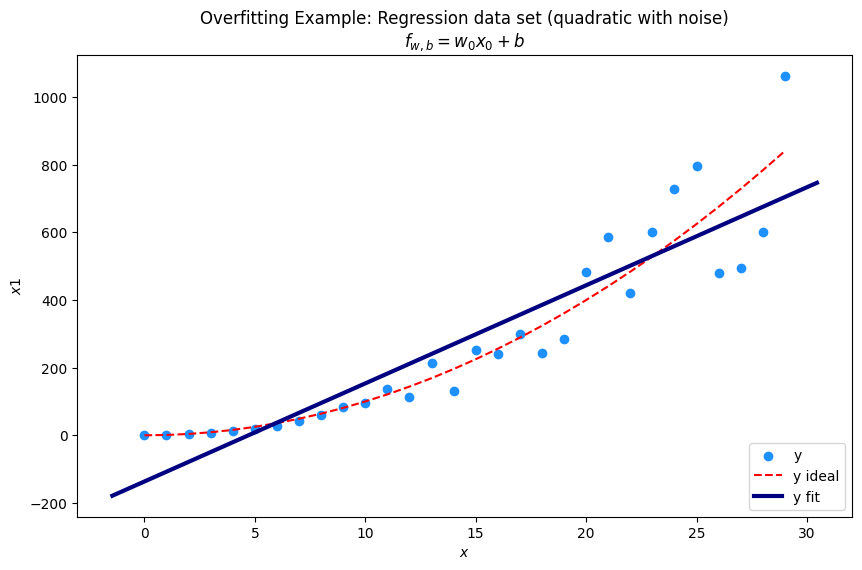

In [10]:
overfit_example(logistic=False, degree=1)

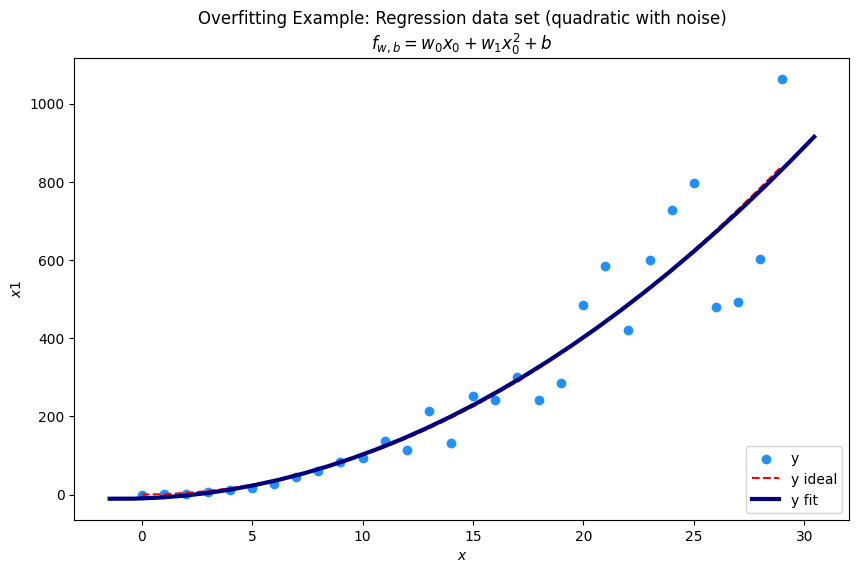

In [11]:
overfit_example(logistic=False, degree=2)

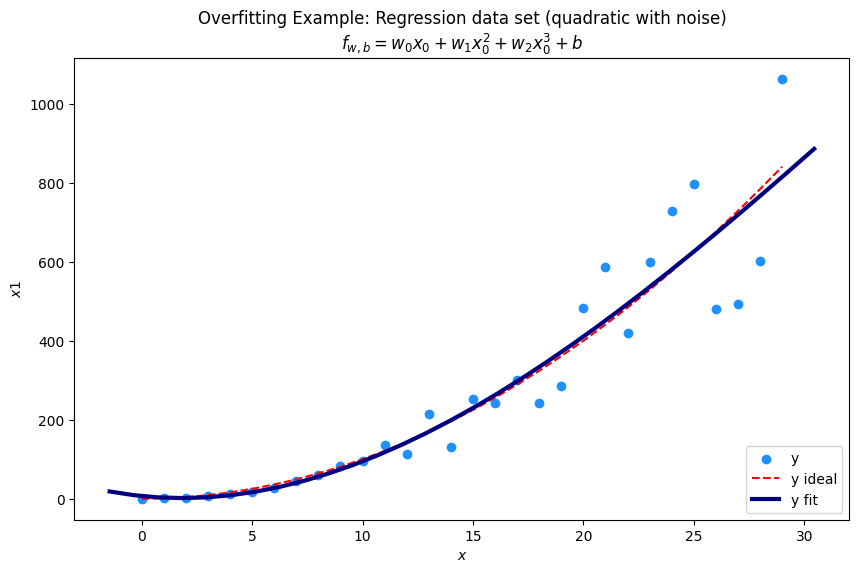

In [12]:
overfit_example(logistic=False, degree=3)

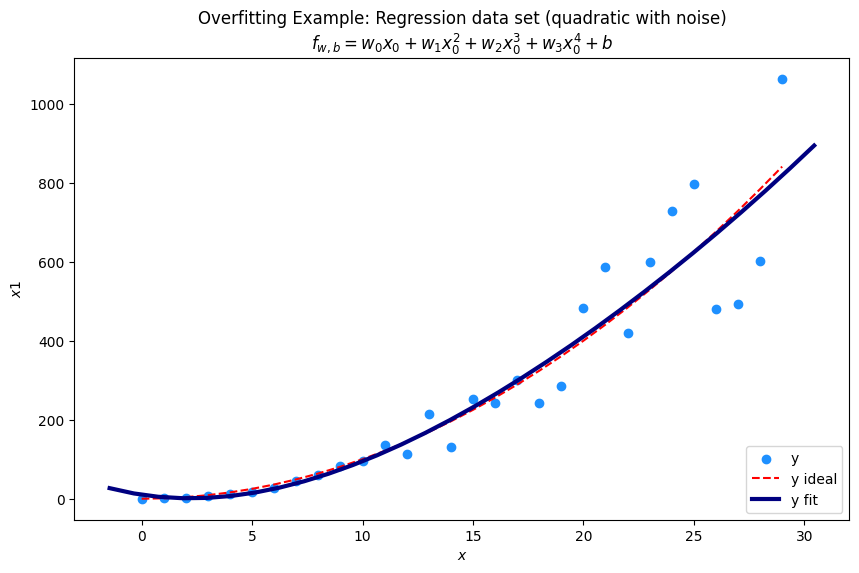

In [13]:
overfit_example(logistic=False, degree=4)

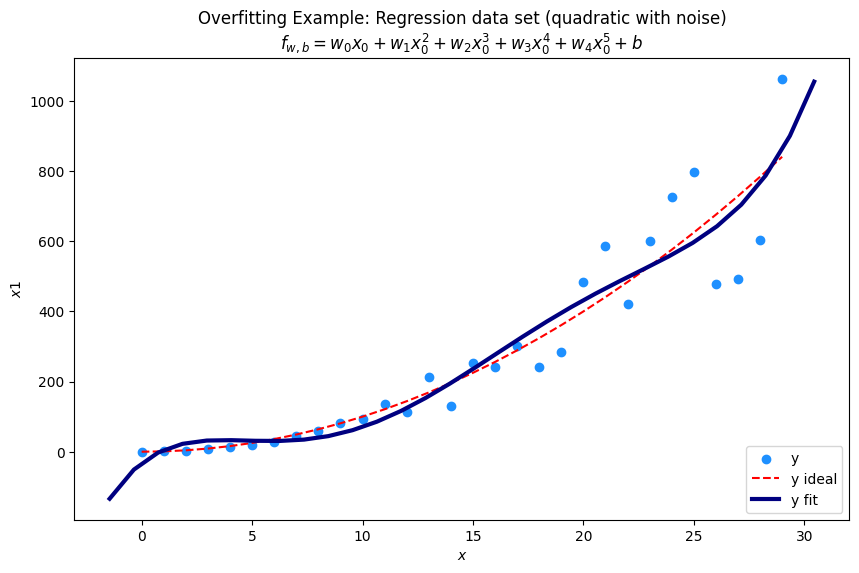

In [14]:
overfit_example(logistic=False, degree=5)

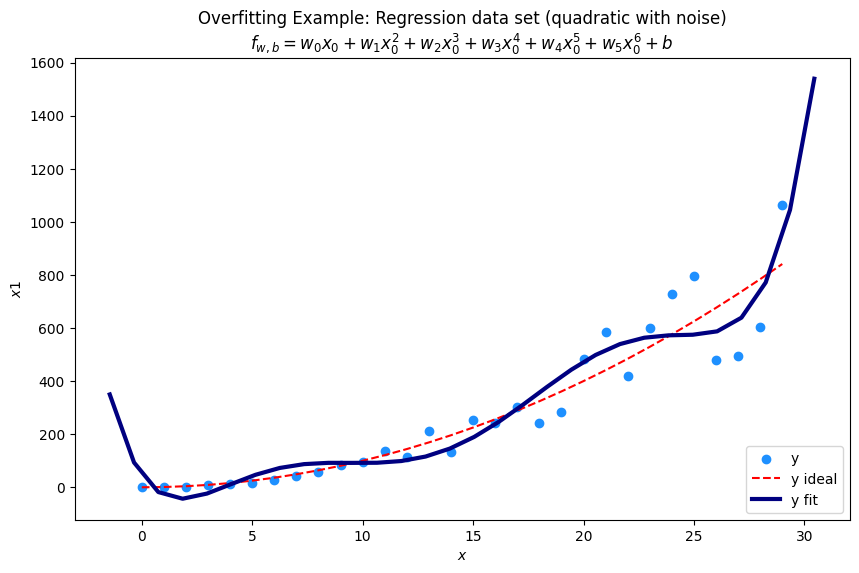

In [15]:
overfit_example(logistic=False, degree=6)

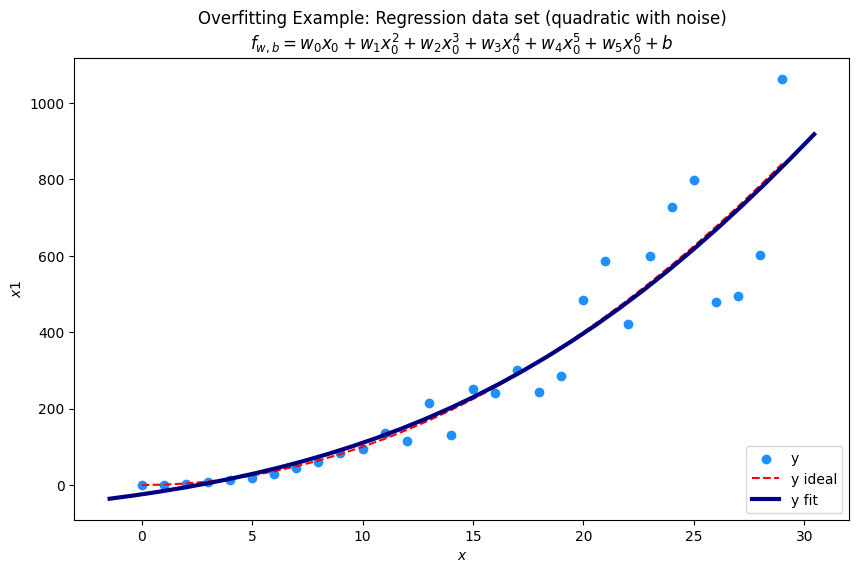

In [16]:
overfit_example(logistic=False, lmbda=0.6, degree=6)

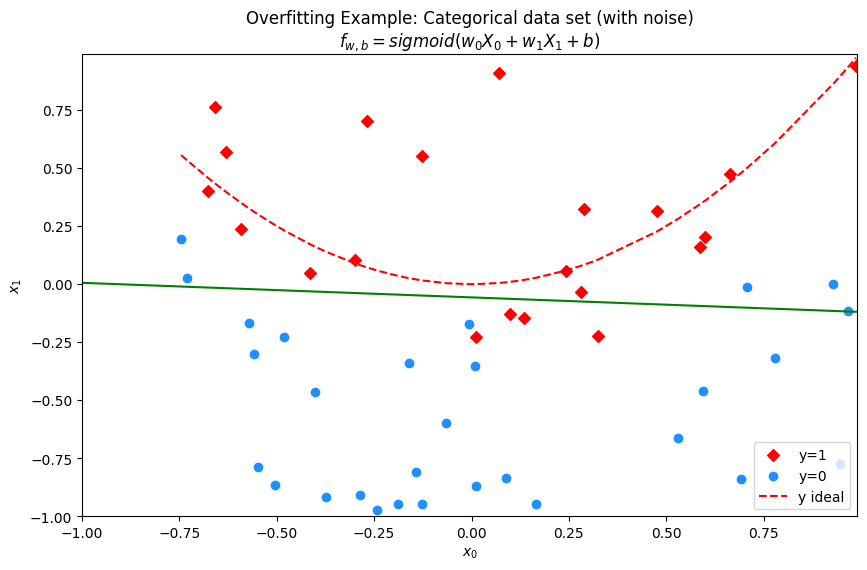

In [17]:
overfit_example(logistic=True, degree=1)

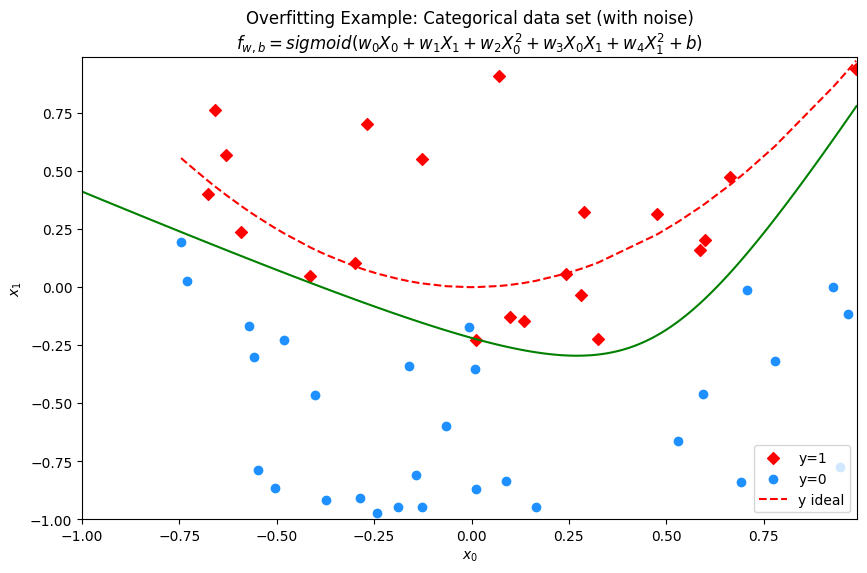

In [18]:
overfit_example(logistic=True, degree=2)

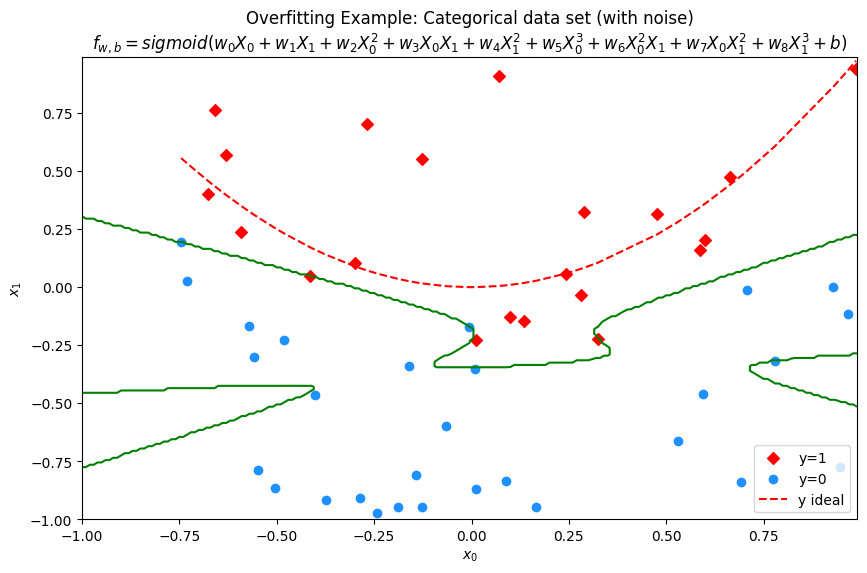

In [19]:
overfit_example(logistic=True, degree=3)

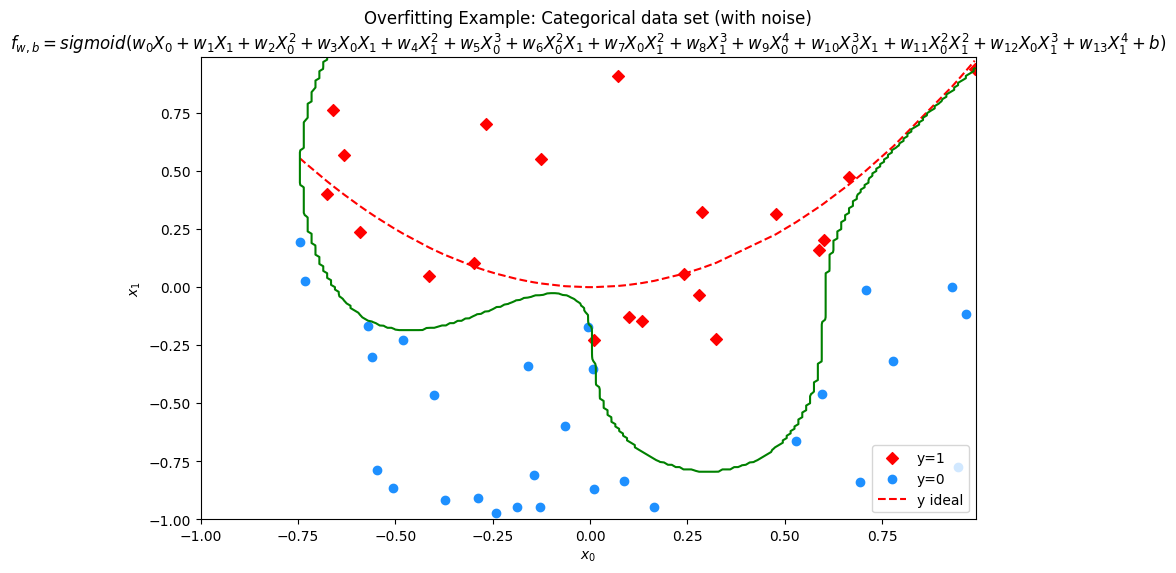

In [20]:
overfit_example(logistic=True, degree=4)

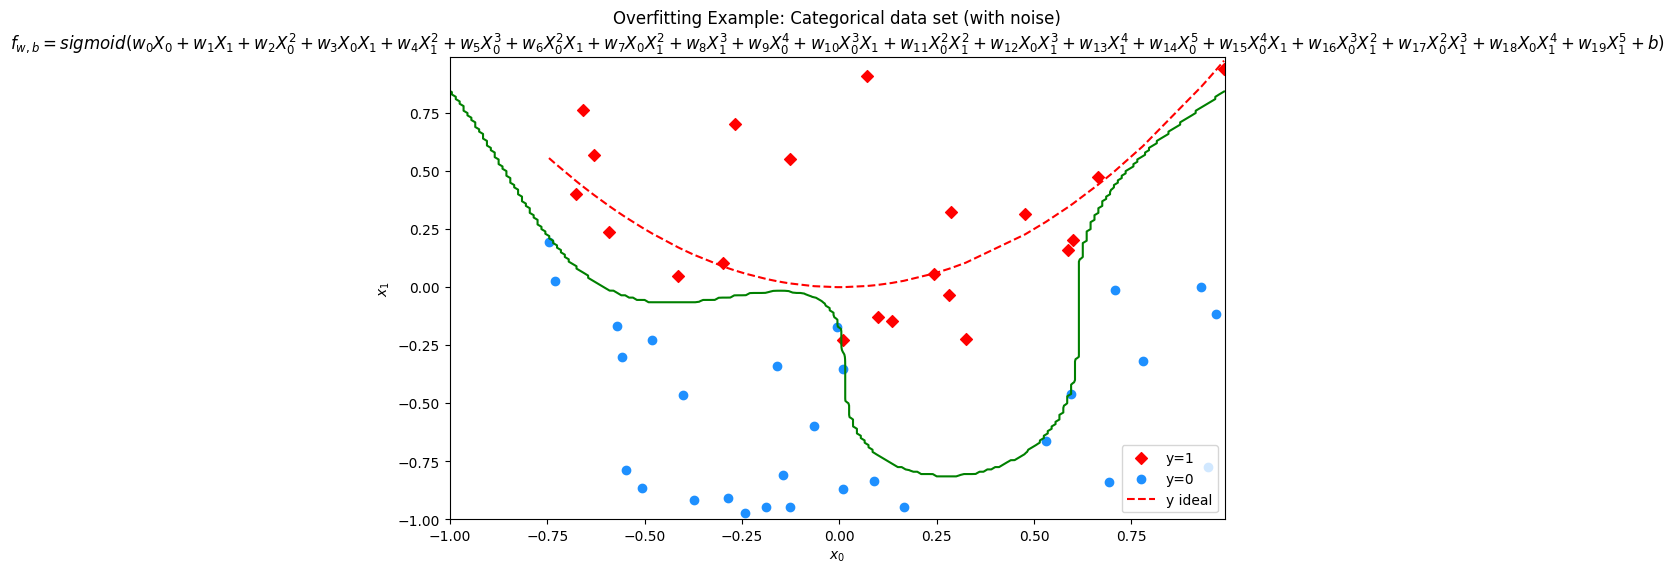

In [21]:
overfit_example(logistic=True, degree=5)

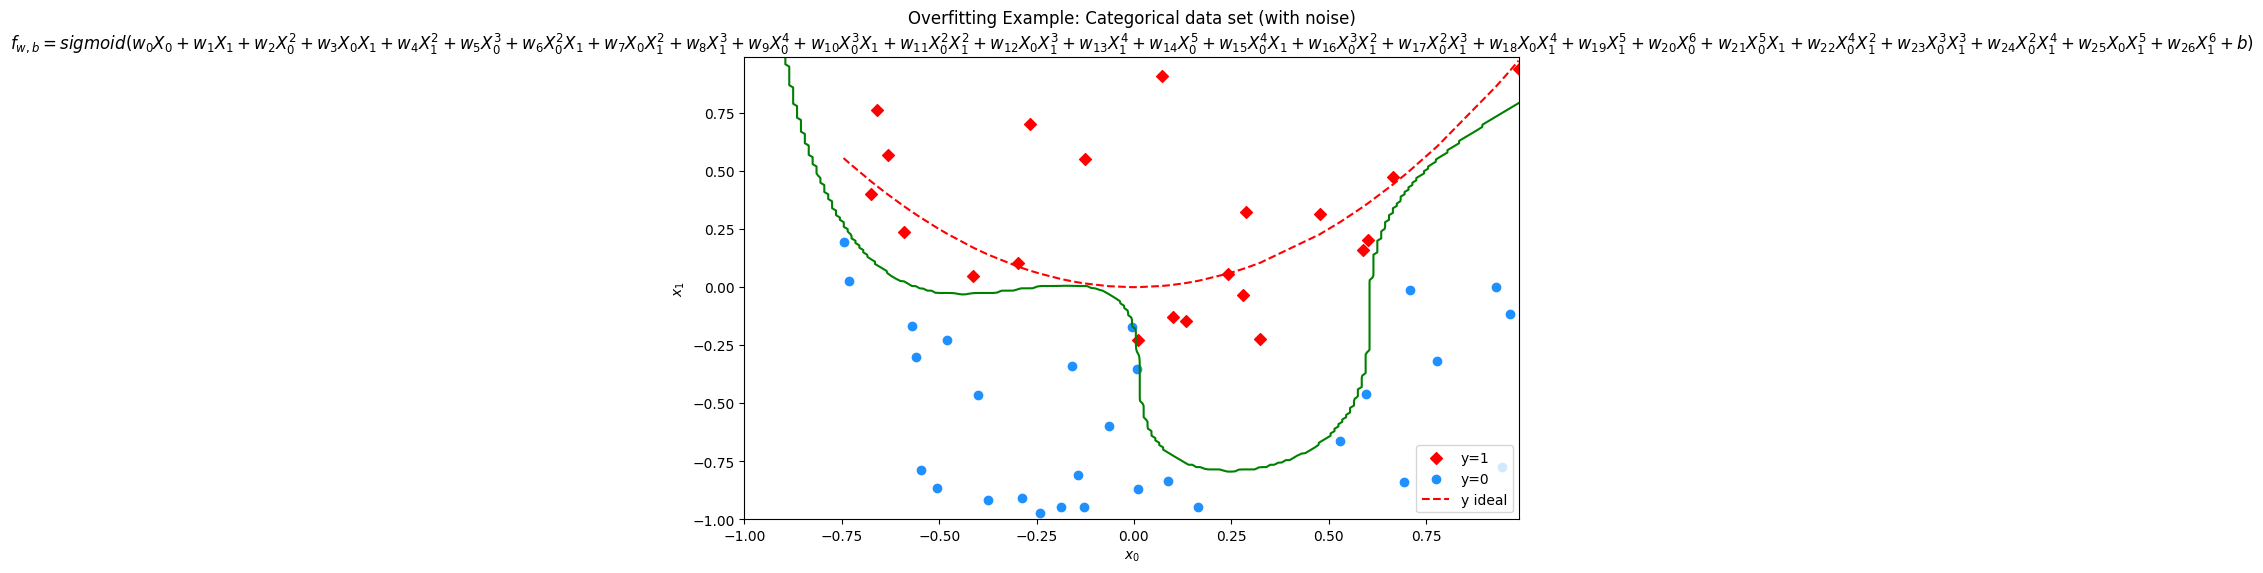

In [22]:
overfit_example(logistic=True, degree=6)

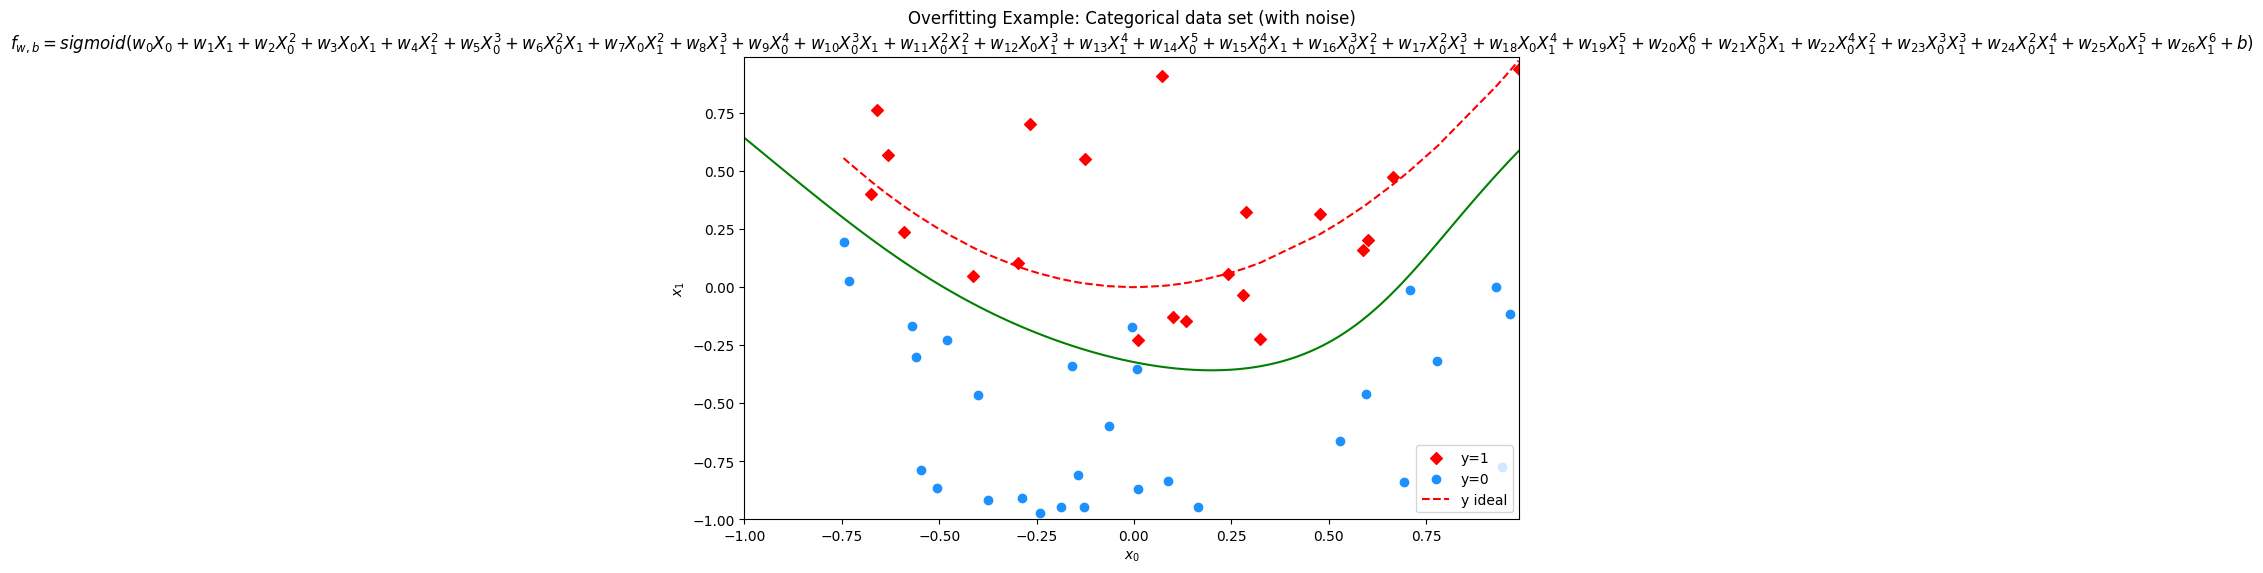

In [23]:
overfit_example(logistic=True, lmbda=0.6, degree=6)